In [88]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [101]:
def drop_out(layer_data, m, keep_prob):
    np.random.seed(2)
    D = {}
    L = len(layer_data)
    for i in range(L):
        D[str(i)] = np.random.rand(layer_data[i], m)
        D[str(i)] = D[str(i)]<keep_prob[i]
    return D

In [90]:
def sigmoid(z):
    A = 1/(1+np.exp(-z))
    cache = z                      #cache is helpful to keep track in backprop
    return A,cache

def relu(z):
    A = np.maximum(0,z)
    cache = z
    return A,cache

def tanh(z):
    A = np.tanh(z)
    cache = z
    return A,cache

In [91]:
def back_sigmoid(dA, cache):              #calculates derivative for backprop
    z = cache
    s = 1/(1+np.exp(-z))
    dz = dA*s*(1-s)
    return dz

def back_relu(dA, cache):
    z = cache
    dz = np.array(dA, copy=True)    
    dz[z<=0] = 0                    #set values to zero which are negative
    return dz

def back_tanh(dA, cache):
    z = cache
    s = np.tanh(z)
    dz = dA*(1-np.square(s))
    return dz

In [92]:
def ini_params_deep(layer_data):
    np.random.seed(1)
    params = {}
    L = len(layer_data)       #no. of layers for finding how many w and b
    for i in range(1,L):
        params['w'+str(i)] = ((np.random.randn(layer_data[i],layer_data[i-1]))/np.sqrt(layer_data[i-1]))  #initialize randomly 
        params['b'+str(i)] = (np.zeros((layer_data[i],1)))               #set b to 0 initially
    return params

In [93]:
def lin_fwd(A,w,b):
    Z = w.dot(A) + b           #the linear caclculation part
    cache = (A,w,b)            #store the result which helps in backprop
    return Z,cache

def lin_act_fwd(A_last,w,b,act):          #activation functions
    if act=='sigmoid':
        Z,lin_cache = lin_fwd(A_last,w,b)
        A,act_cache = sigmoid(Z)
    elif act=='relu':
        Z,lin_cache = lin_fwd(A_last,w,b)
        A,act_cache = relu(Z)
    elif act=='tanh':
        Z,lin_cache = lin_fwd(A_last,w,b)
        A,act_cache = tanh(Z)
     
    cache = (lin_cache,act_cache)           #store, helpful during backprop
    return A, cache

def L_model_fwd_drop(X,params,D,keep_prob):            #integrates all the above for the calculation of forward propagation
    caches = []
    A = X
    A = np.multiply(A, D[str(0)])
    A /= keep_prob[0]
    L = len(params)//2           #calculate the no. of layers, divide by 2 because of w and b
    for i in range(1,L):
        A_last = A
        A, cache = lin_act_fwd(A_last, params['w'+str(i)], params['b'+str(i)], 'relu')      #call linear function
        A = np.multiply(A, D[str(i)])
        A /= keep_prob[i]
        caches.append(cache)
    Al, cache = lin_act_fwd(A, params['w'+str(L)], params['b'+str(L)], 'sigmoid')       #call the activation
    Al = np.multiply(Al, D[str(L)])
    Al /= keep_prob[L]
    caches.append(cache)                         #caches keep store of the values, useful for backprop
    return Al, caches

def L_model_fwd(X,params):            #integrates all the above for the calculation of forward propagation
    caches = []
    A = X
    L = len(params)//2           #calculate the no. of layers, divide by 2 because of w and b
    for i in range(1,L):
        A_last = A
        A, cache = lin_act_fwd(A_last, params['w'+str(i)], params['b'+str(i)], 'relu')      #call linear function
        caches.append(cache)
    Al, cache = lin_act_fwd(A, params['w'+str(L)], params['b'+str(L)], 'sigmoid')       #call the activation
    caches.append(cache)                         #caches keep store of the values, useful for backprop
    return Al, caches

In [94]:
def cost(Al,Y):
    m = Y.shape[1]
    cost = (-np.dot(Y,np.log(Al).T) - np.dot((1-Y),np.log(1-Al).T))/m        #the cost function for binary classifier 
    return cost

In [113]:
def lin_back(dz, cache):                 #part of backprop that finds the derivatives
    A_last, w, b = cache
    m = A_last.shape[1]
    dw = (1./m)*np.dot(dz,A_last.T)                     #derivative for w
    db = (1./m)*np.sum(dz, axis=1, keepdims=True)       #derivative for b
    dA_last = np.dot(w.T,dz)                           #derivative of A or activation
    return dA_last, dw, db

def lin_act_back(dA, cache, act):                #calls the various derivative functions
    lin_cache, act_cache = cache                #recalls the two caches from cache
    if act == 'relu':
        dz = back_relu(dA, act_cache)
        dA_last, dw, db = lin_back(dz, lin_cache)
    elif act == 'sigmoid':
        dz = back_sigmoid(dA, act_cache)
        dA_last, dw, db = lin_back(dz, lin_cache)
    elif act == 'tanh':
        dz = back_tanh(dA, act_cache)
        dA_last, dw, db = lin_back(dz, lin_cache)
    return dA_last, dw, db

def L_model_back(Al, Y, caches,D,keep_prob):                       #the main backward propagation
    grads = {}
    L = len(caches)
    m = Al.shape[1]
    Y = Y.reshape(Al.shape)
    dAl = -(np.divide(Y,Al) - np.divide((1-Y),(1-Al)))        #derivative for final layer
    dAl = np.multiply(dAl, D[str(L)])
    dAl /= keep_prob[L]
    curr_cache = caches[L-1]
    grads['dA'+str(L)], grads['dw'+str(L)], grads['db'+str(L)] = lin_act_back(dAl, curr_cache, 'sigmoid')
    grads['dA'+str(L)] = np.multiply(grads['dA'+str(L)], D[str(L)])
    grads['dA'+str(L)] /= keep_prob[L]
    for i in reversed(range(L-1)):                           #start in reversed for backward prop
        curr_cache = caches[i]
        dA_last_temp, dw_temp, db_temp = lin_act_back(grads['dA'+str(i+2)], curr_cache, 'relu')
        grads['dA'+str(i+1)] = dA_last_temp
        grads['dA'+str(i+2)] = np.multiply(grads['dA'+str(i+2)], D[str(i+2)])
        grads['dA'+str(i+2)] /= keep_prob[i+2]
        grads['dw'+str(i+1)] = dw_temp
        grads['db'+str(i+1)] = db_temp
    return grads                                #grads contains dw, db, and dA

def update(params, grads, lr):              #lr is learning rate
    L = len(params)//2
    for i in range(L):
        params['w'+str(i+1)] = params['w'+str(i+1)] - lr*grads['dw'+str(i+1)]        #update rule for w
        params['b'+str(i+1)] = params['b'+str(i+1)] - lr*grads['db'+str(i+1)]       #update rule for b
    return params

In [114]:
def predict(X, y, params):                         #the prediction function for test set
    m = X.shape[1]
    #n = len(params)
    p = np.zeros((1,m))                            #the predicted output
    probs, caches = L_model_fwd(X, params)
    for i in range(0, probs.shape[1]):
        if probs[0,i]>0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    return p

In [115]:
def L_layer(X, Y, layer_data, keep_prob, lr, num_iter, print_cost=False ):   #train the neural network
    np.random.seed(3)
    m = X.shape[1]
    costs = []
    params = ini_params_deep(layer_data)
    for i in range(0, num_iter):
        D = drop_out(layer_data, m, keep_prob)
        Al, caches = L_model_fwd_drop(X, params, D, keep_prob)
        cost_compute = cost(Al,Y)
        grads = L_model_back(Al, Y, caches, D, keep_prob)
        params = update(params, grads, lr)
        if (print_cost and i%100) == 0:
            print('Cost after iteration %i: %f' %(i, cost_compute))       #print the value of costs after 100 iterations
        if (print_cost and i%100) == 0:
            costs.append(cost_compute)
    plt.plot(np.squeeze(costs))                    #plot the costs vs. iterations
    plt.ylabel('cost')
    plt.xlabel('iterations(per tens)')
    plt.title('learning rate = '+str(lr))
    plt.show()
    return params

In [116]:
def data():
    data_orig = pd.read_csv('housepricedata.csv')           #read data in pandas dataframe
    X_orig = data_orig.iloc[:,0:10].values                  #convert to numpy array
    m = X_orig.shape[0]
    Y_orig = data_orig.iloc[:,10].values.reshape(m,1)
    X_train, X_test, Y_train, Y_test = train_test_split(X_orig, Y_orig, test_size=0.2)       #randomly split into 80-20 train-test set 
    scale = preprocessing.StandardScaler().fit(X_train)
    X_train_new = scale.transform(X_train)                #after processing the data using skLearn library
    X_test_new = scale.transform(X_test)                  #for getting a standard data range for all the features
    X = X_train_new.T
    Y = Y_train.T
    X_t = X_test_new.T
    Y_t = Y_test.T
    n_x = X.shape[0]                  #input nodes
    n_y = Y.shape[0]                #output nodes
    layer_data = [n_x,25, 25, n_y]         #specifies how many layers and how many nodes in each layer
    return X, Y, X_t, Y_t, layer_data

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[10, 25, 25, 1]
Cost after iteration 0: 0.868856
Cost after iteration 100: 0.769541
Cost after iteration 200: 0.711470
Cost after iteration 300: 0.665667
Cost after iteration 400: 0.625377
Cost after iteration 500: 0.588460
Cost after iteration 600: 0.553333
Cost after iteration 700: 0.519918
Cost after iteration 800: 0.488609
Cost after iteration 900: 0.459666
Cost after iteration 1000: 0.433832
Cost after iteration 1100: 0.411356
Cost after iteration 1200: 0.392427
Cost after iteration 1300: 0.376662
Cost after iteration 1400: 0.363551
Cost after iteration 1500: 0.352620
Cost after iteration 1600: 0.343546
Cost after iteration 1700: 0.335890
Cost after iteration 1800: 0.329301
Cost after iteration 1900: 0.323598
Cost after iteration 2000: 0.318587
Cost after iteration 2100: 0.314134
Cost after iteration 2200: 0.310053
Cost after iteration 2300: 0.306252
Cost after iteration 2400: 0.302709
Cost after iteration 2500: 0.299397
Cost after iteration 2600: 0.296272
Cost after iteration 270

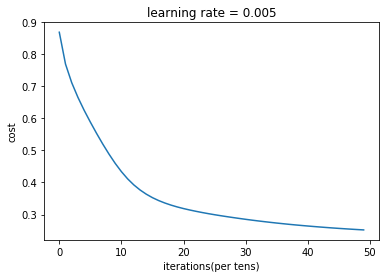

The F-score: 0.879121 and accuracy: 0.886986


In [118]:
X, Y, X_t, Y_t, layer_data = data()        #get the data

print(layer_data)                         #prints the no. of layers and hidden nodes in each
keep_prob = [1,1,0.5,1]

params = L_layer(X,Y,layer_data,keep_prob,0.005,5000,True)         #train the data and find the parameters

p = predict(X_t, Y_t, params)                         #find the predicted output on the test set
TP = np.sum(np.logical_and(p==1,Y_t==1))              #true positive
TN = np.sum(np.logical_and(p==0,Y_t==0))              #true negative
FP = np.sum(np.logical_and(p==1,Y_t==0))              #false positive
FN = np.sum(np.logical_and(p==0,Y_t==1))              #false negative

P=TP/(TP+FP)                                          #precision
R=TP/(TP+FN)                                          #recall
F=(2*P*R)/(P+R)                                       #F-score
accuracy = (TP+TN)/(TP + TN + FP + FN)                #accuracy
print("The F-score: %f and accuracy: %f" %(F,accuracy))